In [4]:
import torch
import torchvision
from dataset import SingleChannelNDIDatasetContrastiveLearningWithAug
from pathlib import Path
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from PIL import Image
from typing import Union

In [68]:
def show_tensor(img_tensor: torch.Tensor, num_img_per_row: int=6, figsize:Union[tuple, list]=(12, 12)):
    num_channels = img_tensor.size(0)
    n_rows = num_channels // num_img_per_row
    fig, axes = plt.subplots(n_rows, num_img_per_row, figsize=figsize)
    for i in range(n_rows):
        for j in range(num_img_per_row):
            idx = i * num_img_per_row + j
            if idx < num_channels:
                tensor = img_tensor[idx]
                assert tensor.dim() in (2, 3)
                img = tensor.numpy()
                if tensor.dim() == 3:
                    img = img.transpose(1, 2, 0)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
            else:
                axes[i, j].remove()
    plt.subplots_adjust(wspace=0.05, hspace=-0.8)
    plt.show()

def get_model():
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    temp = torch.load(f'./checkpoints/ImageNet_ALL_CHECK_400_Epoch.pth')['state_dict']
    state_dict = {}
    for k, v in temp.items():
        if 'encoder_q' in k:
            if 'fc' not in k:
                state_dict['.'.join(k.split('.')[1:])] = v
    base_encoder.load_state_dict(state_dict)
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

def get_intermediate_output_ResNet(model: torchvision.models.ResNet, inputs: torch.Tensor):
    x = inputs
    output = []
    for i, layer in enumerate(list(model.children())):
        x = layer(x)
        if i in (4, 5, 6, 7):
            output.append(x)
        if i == 8:
            x = torch.flatten(x, 1)
    return output
        

In [44]:
ORIGINAL_IMAGE = '../datasets/NDI_images/Integreted/Observed/'
TARGET_IMAGE = '../datasets/NDI_images/Integreted/Calculated/'
original_images = list(sorted(list(map(str, list(Path(ORIGINAL_IMAGE).glob('*.jpg'))))))
target_images = list(sorted(list(map(str, list(Path(TARGET_IMAGE).glob('*.jpg'))))))
images = list(reversed(list(zip(original_images, target_images))))
train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug([images, []], False, 200)
train_iter = DataLoader(train_dataset, 1, shuffle=True, drop_last=True)

with torch.no_grad():
    origin, target, label = next(iter(train_iter))
    model = get_model()
    origin_inter, target_inter = get_intermediate_output_ResNet(model, origin), get_intermediate_output_ResNet(model, target)


/home/gp.sc.cc.tohoku.ac.jp/duanct/miniconda3/envs/py2cuda118/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 64, 100, 100])
torch.Size([1, 64, 100, 100])
torch.Size([1, 64, 100, 100])
torch.Size([1, 64, 50, 50])
torch.Size([1, 256, 50, 50])
torch.Size([1, 512, 25, 25])
torch.Size([1, 1024, 13, 13])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 1, 1])
torch.Size([1, 512])
torch.Size([1, 64, 100, 100])
torch.Size([1, 64, 100, 100])
torch.Size([1, 64, 100, 100])
torch.Size([1, 64, 50, 50])
torch.Size([1, 256, 50, 50])
torch.Size([1, 512, 25, 25])
torch.Size([1, 1024, 13, 13])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 1, 1])
torch.Size([1, 512])


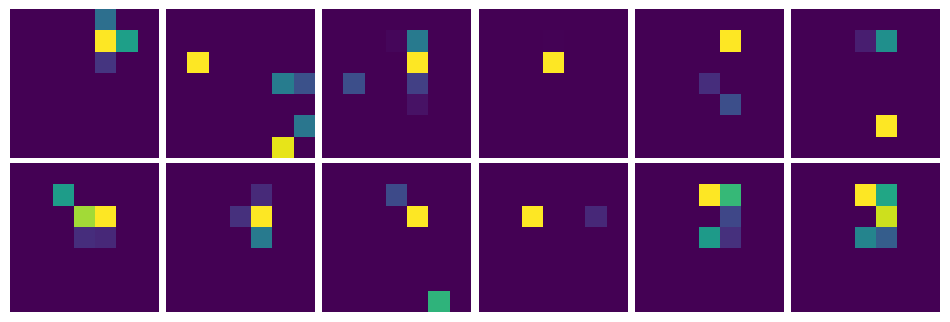

In [78]:
show_tensor(origin_inter[3][0][:12])

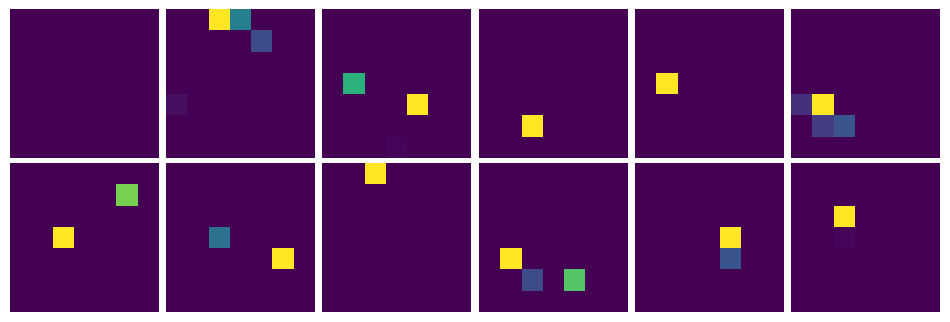

In [79]:
show_tensor(target_inter[3][0][:12])